In [4]:
import numpy as np
import pandas as pd
from fullfrlm import flow_refueling_location_model
import pickle
import networkx as nx
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))

In [2]:
df_h

,Unnamed: 0,country,city_abbr,city_full,function,coords,harbour_code,lat,lon,harbour_node
0,78676,NL,ABL,Alblasserdam,1-------,nan,NLABL,51.861514,4.657490,8866686
1,78678,NL,ALK,Alkmaar,123-----,5238N 00445E,NLALK,52.633333,4.750000,8861625
2,78680,NL,ALM,Almelo,123-----,5221N 00640E,NLALM,52.350000,6.666667,8866425
3,78682,NL,AER,Almere,1-3--6--,5222N 00513E,NLAER,52.366667,5.216667,8864005
4,78685,NL,APN,Alphen aan den Rijn,123-----,5208N 00440E,NLAPN,52.133333,4.666667,8863360
...,...,...,...,...,...,...,...,...,...,...
65,80378,NL,WTE,West-Terschelling,1-------,nan,NLWTE,53.362705,5.216893,8865605
66,80438,NL,WMO,Wormer,1-3-----,5230N 00449E,NLWMO,52.500000,4.816667,8866889
67,80450,NL,ZAA,Zaandam,123-----,nan,NLZAA,52.442040,4.829199,8866889
68,80514,NL,ZWI,Zwijndrecht,123-----,nan,NLZWI,51.810598,4.627272,8865003


In [3]:
total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_abm, flows = flow_refueling_location_model(1, 50000, 100, 5, 5, 30, vis=False)

Optimal


In [4]:
nodes = []
for route in non_zero_flows.keys():
    nodes += paths[route]

nodes = list(set(nodes))

G = G.subgraph(nodes)

In [5]:
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [6]:
df_nodes = df_nodes.loc[df_nodes.index.isin(nodes)]

In [7]:
df_nodes.fillna(0, inplace=True)
df_nodes['model_type'] =df_nodes.n.apply(lambda x: "harbour" if ((len(str(x))>4) and (x in df_h.harbour_node.unique())) else x)
df_nodes.model_type = df_nodes.model_type.apply(lambda x: "inserted_node" if x==0 else x)
df_nodes.model_type = df_nodes.model_type.apply(lambda x: "intermediate_node" if str(x).isdigit() else x)

In [8]:
def cs_harbour_or_both(col1, col2):
    to_r = col2
    if col1 !=0:
        if col2 == 'inserted_node':
            to_r = 'charging_station'
        else:
            to_r = 'harbour_with_charging'
    return to_r


def gen_link_name(col1, col2):
    return tuple([col1, col2])


def find_middle_x(val1, val2):
    x1 = df_nodes.loc[df_nodes.name == val1].X.item()
    x2 = df_nodes.loc[df_nodes.name == val2].X.item()
    return (x1+x2)/2


def find_middle_y(val1, val2):
    y1 = df_nodes.loc[df_nodes.name == val1].Y.item()
    y2 = df_nodes.loc[df_nodes.name == val2].Y.item()
    return (y1+y2)/2

In [9]:
df_nodes['index1'] = df_nodes.index
df_nodes['charging_stations'] = df_nodes.index1.apply(lambda x: optimal_facilities[x] if (x in df_h.harbour_node.unique()) or (len(str(x)) == 3) else 0)
df_nodes.model_type = df_nodes.apply(lambda x: cs_harbour_or_both(x.charging_stations, x.model_type), axis=1)
df_nodes.drop(columns=['index1', 'n', 'geometry', 'Wkt'], inplace=True)

In [10]:
df_nodes.reset_index(inplace=True)
df_nodes.rename(columns={'index':'name'}, inplace=True)
df_nodes['source'] = np.nan
df_nodes['target'] = np.nan
df_nodes['length_m'] = np.nan

In [11]:
df_links = nx.to_pandas_edgelist(G)

In [12]:
df_links = df_links.loc[:, ['source', 'target', 'length_m']]
df_links['X'] = df_links.apply(lambda x: find_middle_x(x.source, x.target), axis=1)
df_links['Y'] = df_links.apply(lambda x: find_middle_y(x.source, x.target), axis=1)
df_links['name'] = df_links.apply(lambda x: gen_link_name(x.source, x.target), axis=1)
df_links['charging_stations'] = np.nan
df_links['model_type'] = 'link'

In [13]:
df_links

,source,target,length_m,X,Y,name,charging_stations,model_type
0,8868266,8862690,21177.666942,5.618545,52.516363,"(8868266, 8862690)",NaN,link
1,8862592,8864384,4659.573898,4.931344,52.380744,"(8862592, 8864384)",NaN,link
2,8862592,8863796,1460.643918,4.904284,52.381537,"(8862592, 8863796)",NaN,link
3,8863630,8863818,7765.172161,4.835893,51.681540,"(8863630, 8863818)",NaN,link
4,8863630,8861698,18595.653878,4.742829,51.716376,"(8863630, 8861698)",NaN,link
...,...,...,...,...,...,...,...,...
92,8862202,8862340,1104.093208,5.357355,51.953953,"(8862202, 8862340)",NaN,link
93,8863710,8864009,2629.815807,4.495290,51.912952,"(8863710, 8864009)",NaN,link
94,8865140,8866686,1910.607370,4.624423,51.882727,"(8865140, 8866686)",NaN,link
95,8866570,8863048,2859.510386,4.664164,51.840048,"(8866570, 8863048)",NaN,link


In [14]:
df_abm = pd.concat([df_links, df_nodes])
df_abm.reset_index(inplace=True)
df_abm.rename(columns={'index':'id'}, inplace=True)

In [15]:
df_abm

,id,source,target,length_m,X,Y,name,charging_stations,model_type
0,0,8868266,8862690,21177.666942,5.618545,52.516363,"(8868266, 8862690)",NaN,link
1,1,8862592,8864384,4659.573898,4.931344,52.380744,"(8862592, 8864384)",NaN,link
2,2,8862592,8863796,1460.643918,4.904284,52.381537,"(8862592, 8863796)",NaN,link
3,3,8863630,8863818,7765.172161,4.835893,51.681540,"(8863630, 8863818)",NaN,link
4,4,8863630,8861698,18595.653878,4.742829,51.716376,"(8863630, 8861698)",NaN,link
...,...,...,...,...,...,...,...,...,...
192,95,NaN,NaN,NaN,4.639279,52.326437,123,1.0,charging_station
193,96,NaN,NaN,NaN,4.436741,51.676455,112,2.0,charging_station
194,97,NaN,NaN,NaN,4.792471,52.531953,131,1.0,charging_station
195,98,NaN,NaN,NaN,5.063732,52.163471,132,0.0,inserted_node


Optimal


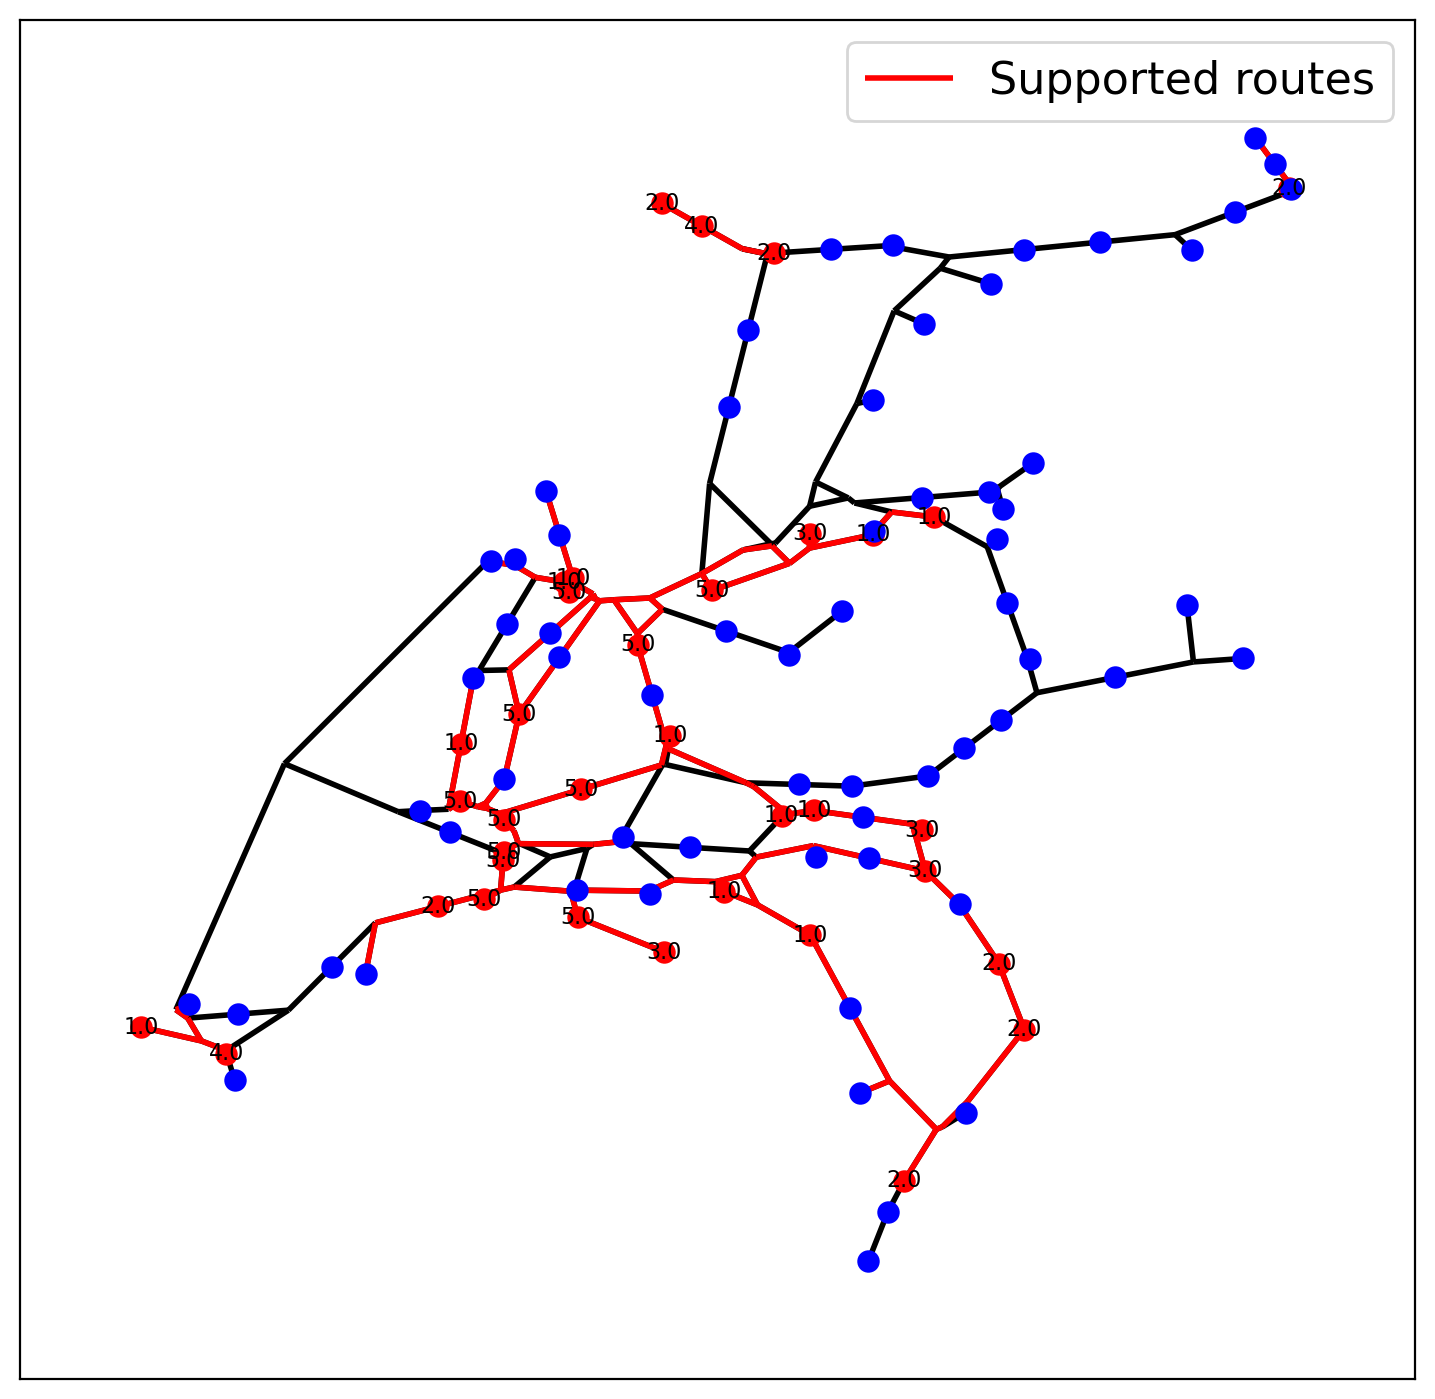

In [16]:
total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_abm, flows = flow_refueling_location_model(1, 100000, 100, 5, 5, 30, vis=True)

,id,source,target,length_m,X,Y,name,charging_stations,model_type,range,capacity
0,1000,30986055,8867600,8380.518917,5.365231,53.183419,"(30986055, 8867600)",NaN,link,100000,5
1,1001,30986055,8865756,2481.139176,5.412350,53.178500,"(30986055, 8865756)",NaN,link,100000,5
2,1002,11309058,8865990,18936.187403,5.450226,51.645417,"(11309058, 8865990)",NaN,link,100000,5
3,1003,11309058,8866775,11560.215727,5.324146,51.695530,"(11309058, 8866775)",NaN,link,100000,5
4,1004,11309058,11309119,9235.019525,5.349926,51.714149,"(11309058, 11309119)",NaN,link,100000,5
...,...,...,...,...,...,...,...,...,...,...,...
258,1258,NaN,NaN,NaN,6.888270,53.384504,122,0.0,inserted_node,100000,5
259,1259,NaN,NaN,NaN,4.764483,52.304545,125,0.0,inserted_node,100000,5
260,1260,NaN,NaN,NaN,5.682730,51.881516,130,0.0,inserted_node,100000,5
261,1261,NaN,NaN,NaN,4.792471,52.531953,131,0.0,inserted_node,100000,5


In [18]:
df_abm.model_type.unique()

array(['link', 'intermediate_node', 'harbour_with_charging', 'harbour',
       'charging_station', 'inserted_node'], dtype=object)

In [19]:
pickle.dump(G, open("ABM/own_work/data/network.p", "wb"))
pickle.dump(paths, open("ABM/own_work/data/paths.p", "wb"))
pickle.dump(flows, open("ABM/own_work/data/total_flow.p", "wb"))
pickle.dump(df_abm, open("ABM/own_work/data/df_abm.p", "wb"))

In [20]:
df_abm.to_csv('ABM/own_work/data/df_abm.csv')

In [22]:
df1 = pd.read_excel('data/ship_types.xlsx')

In [23]:
df1

,RWS-class,Engine power averge [kW],Factor,CEMT-class
0,M0,NaN,NaN,0
1,M1,175.0,1.000000,I
2,M2,300.0,1.714286,II
3,M3,435.0,2.485714,III
4,M4,435.0,2.485714,III
5,M5,435.0,2.485714,III
6,M6,690.0,3.942857,IV
7,M7,690.0,3.942857,IV
8,M8,1425.0,8.142857,V_A
9,M9,1425.0,8.142857,V_A


In [52]:
optimal_flows = pickle.load(open('ABM/own_work/data/optimal_flows.p', 'rb'))
import re

In [66]:
non_zero_flows = {}
for key, item in optimal_flows.items():
    if item != 0:
        a = (re.sub('''["'_']''', "", key[16:35]).split(','))
        a = tuple([a[0], a[1], int(a[2])])
        non_zero_flows[a] = {'combinations': [], 'flows': []}

In [67]:
for key, item in optimal_flows.items():
    if item != 0:
        a = (re.sub('''["'_']''', "", key[16:35]).split(','))
        a = tuple([a[0], a[1], int(a[2])])
        b = key[40:-3].split("',_'")
        if len(b) == 1:
            b[0] = re.sub("[']", "", b[0])
        non_zero_flows[a]['combinations'].append(b)
        non_zero_flows[a]['flows'].append(item)

In [69]:
non_zero_flows[('NLAMS', 'NLAER', 0)]

{'combinations': [['8866763', '8864005']], 'flows': [0.5437747]}

In [70]:
paths[('NLAMS', 'NLAER', 0)]

NameError: name 'paths' is not defined